In [57]:
import importlib
import sys
sys.path.append('../src')

import qa
importlib.reload(qa)
import qa
from plot import plot_from_file

import pickle
import numpy as np
import pandas as pd

import re
import random
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import pearsonr

# Plotting workspace

In [ ]:
PATH = '../data/MMLU-Pro/sample_results/mmlu_list_ad.pkl'
results = pickle.load(open(PATH, 'rb'))
accuracy = [r['r^org']==r['answer'] for r in results]
conf = [r['p_r^org'] for r in results]



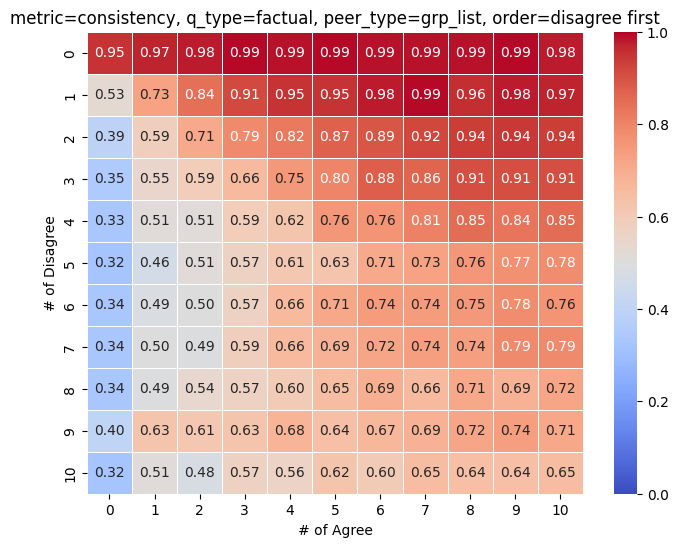

In [ ]:
PATH = '../data/MMLU-Pro/sample_results/mmlu_list_da.pkl'
plot_from_file(PATH, metric = 'consistency', vlimit=(0,1))


# Data Generation

## MMLU

In [ ]:
# from datasets import load_dataset

# ds = load_dataset("TIGER-Lab/MMLU-Pro")

# mmlu = {}
# for ele in ds['test']:
#     if ele['category'] not in mmlu:
#         mmlu[ele['category']] = []
#     mmlu[ele['category']].append(ele)

# import random

# # mmlu_samples = []
# # for cat in mmlu:
# #     mmlu_samples.extend(random.Random(0).sample(mmlu[cat], 10))

# # with open('../data/mmlu_samples_140.pkl', 'wb') as f:
# #     pickle.dump(mmlu_samples, f)

# mmlu_full = []
# for cat in mmlu:
#     mmlu_full.extend(mmlu[cat])
    
# with open('../data/MMLU-Pro/results/mmlu_full.pkl', 'wb') as f:
#     pickle.dump(mmlu_full, f)

# print("total number of questions in MMLU-Pro:", len(mmlu_full))

# res_oqa_org = qa.qa_eval_org(mmlu_full)

# with open('../data/MMLU-Pro/results/mmlu_org.pkl', 'wb') as f:
#     pickle.dump(res_oqa_org, f)

/home/jch0/.conda/envs/jch0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|██████████| 70/70 [00:00<00:00, 19347.70 examples/s]


total number of questions in MMLU-Pro: 12032


Processing MMLU: 100%|██████████| 12032/12032 [03:19<00:00, 60.35it/s] 


In [ ]:
# with open('../data/MMLU-Pro/results/mmlu_org.pkl', 'rb') as f:
#     res_mmlu_org = pickle.load(f)

# type_names = ['1st', '2nd', 'rnd', 'lst']
# for disagree_type in type_names:
#     results = qa.qa_eval_one(res_mmlu_org, disagree_type)

#     with open(f'../data/MMLU-Pro/results/mmlu_one_{disagree_type}.pkl', 'wb') as f:
#         pickle.dump(results, f)

Processing MMLU: 100%|██████████| 12032/12032 [03:22<00:00, 59.41it/s] 


In [ ]:
with open('../data/MMLU-Pro/sample_results/mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)


input_feat_list = []
for disagree_size in range(11): # row
    input_row = []
    for agree_size in range(11): # column
        
        eval_feat = {
            'type': 'grp_list',
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
            'q_type': 'factual',
            'order': 'da'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_mmlu_org, input_feat_list)

with open('../data/MMLU-Pro/sample_results/mmlu_list_da.pkl', 'wb') as f:
    pickle.dump(results, f)


Processing grp_list samples...


Processing QA: 100%|██████████| 16940/16940 [04:25<00:00, 63.74it/s] 


In [ ]:
with open('../data/MMLU-Pro/sample_results/res_mmlu_org.pkl', 'rb') as f:
    res_mmlu_org = pickle.load(f)


input_feat_list = []
for group_size in [4,12,50,100,1000]: # row
    input_row = []
    for agree_ratio in [0, 0.25, 0.50, 0.75, 1]: # column
        
        eval_feat = {
            'type': 'grp_ratio',
            'group_size': group_size,
            'disagree_ratio': 1-agree_ratio,
            'disagree_type': '2nd',
            'q_type': 'factual',
            'order': 'ad'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_mmlu_org, input_feat_list)
    #     result, accuracy = qa.qa_eval_matrix(res_mmlu_org, eval_feat)
    #     output_row.append(accuracy)
    # output_list.append(output_row)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/MMLU-Pro/sample_results/mmlu_ratio_ad.pkl', 'wb') as f:
    pickle.dump(results, f)


### Reason Generation and Reason in-context

In [ ]:
# with open('../data/MMLU-Pro/sample_results/res_mmlu_org.pkl', 'rb') as f:
#     res_mmlu_org = pickle.load(f)

# mmlu_org_reason = qa.qa_generate_reason(res_mmlu_org, '2nd', 10)

# with open('../data/MMLU-Pro/sample_results/mmlu_org_reason.pkl', 'wb') as f:
#     pickle.dump(mmlu_org_reason, f)

Generating reasons: 100%|██████████| 2800/2800 [05:15<00:00,  8.86it/s]


In [ ]:
with open('../data/MMLU-Pro/sample_results/mmlu_org_reason.pkl', 'rb') as f:
    mmlu_org_reason = pickle.load(f)

input_feat_list = []
for disagree_size in range(11): # row
    input_row = []
    for agree_size in range(11): # column
        
        eval_feat = {
            'type': 'grp_disc',
            'use_reason': True,
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
            'q_type': 'factual',
            'order': 'da'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(mmlu_org_reason, input_feat_list)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/MMLU-Pro/sample_results/mmlu_reason_da.pkl', 'wb') as f:
    pickle.dump(results, f)



Processing grp_discrete samples...


Processing QA: 100%|██████████| 16940/16940 [06:27<00:00, 43.67it/s] 


### bar plot for self-confidence vs consistency

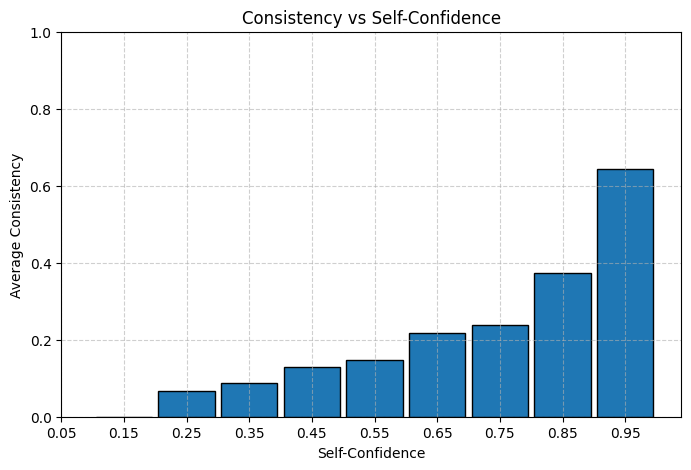

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load data
PATH = '../data/MMLU-Pro/results/mmlu_one_2nd.pkl'
with open(PATH, 'rb') as f:
    results = pickle.load(f)

# Extract accuracy and confidence
accuracy = np.array([r['r'] == r['answer'] for r in results])
consistency = np.array([r['r'] == r['r^org'] for r in results])
self_conf = np.array([r['p_r^org'] for r in results])
other_conf = np.array([r['p_r_j'] for r in results])

# Bin confidence scores into 10 bins from 0 to 1
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(self_conf, bins) - 1  # Adjust bin index to start at 0

# Calculate average accuracy for each bin
bin_accuracy = []
bin_centers = []

for i in range(10):
    indices = bin_indices == i
    if np.any(indices):
        avg_acc = consistency[indices].mean()
    else:
        avg_acc = np.nan
    bin_accuracy.append(avg_acc)
    bin_centers.append((bins[i] + bins[i+1]) / 2)

# Plot the bar chart
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, bin_accuracy, width=0.09, edgecolor='black')
plt.xlabel('Self-Confidence')
plt.ylabel('Average Consistency')
plt.title('Consistency vs Self-Confidence')
plt.xticks(np.round(bin_centers, 2))
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### in/out-domain

In [ ]:
# with open('../data/MMLU-Pro/results/mmlu_org.pkl', 'rb') as f:
#     res_mmlu_org = pickle.load(f)

# results = qa.qa_eval_domain(res_mmlu_org, '2nd')

# with open(f'../data/MMLU-Pro/results/mmlu_domain_2nd.pkl', 'wb') as f:
#     pickle.dump(results, f)


Processing QA: 100%|██████████| 24064/24064 [05:37<00:00, 71.21it/s] 


In [ ]:
# domains = set()
# for ele in res_mmlu_org:
#     domains.add(ele['category'])

# print("total number of domains in MMLU-Pro:", len(domains))
# print("domains in MMLU-Pro:", domains)

total number of domains in MMLU-Pro: 14
domains in MMLU-Pro: {'math', 'engineering', 'physics', 'computer science', 'chemistry', 'psychology', 'law', 'economics', 'philosophy', 'history', 'biology', 'other', 'business', 'health'}


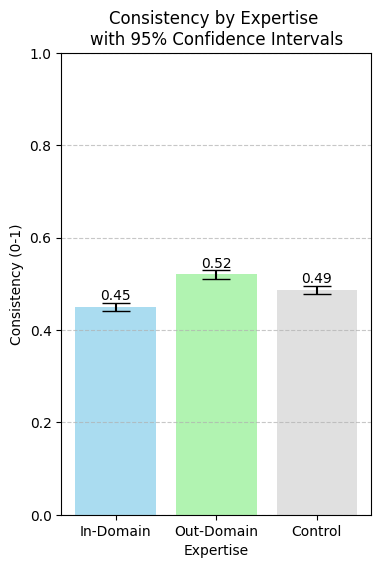

In [ ]:
with open('../data/MMLU-Pro/results/mmlu_domain_2nd.pkl', 'rb') as f:
    results = pickle.load(f)

with open('../data/MMLU-Pro/results/mmlu_one_2nd.pkl', 'rb') as f:
    res_mmlu_one = pickle.load(f)

results_in_domain = results['in_domain']
results_out_domain = results['out_domain']
results_control = res_mmlu_one

consistence_in_domain  = np.array([r['r'] == r['r^org'] for r in results_in_domain])
consistence_out_domain   = np.array([r['r'] == r['r^org'] for r in results_out_domain])
consistence_control = np.array([r['r'] == r['r^org'] for r in results_control])

# Calculate means and confidence intervals
domain_groups = [consistence_in_domain, consistence_out_domain, consistence_control]
mean_consistance = [group.mean() for group in domain_groups]
confidence_intervals = [stats.t.interval(
    0.95, len(group)-1, loc=group.mean(), scale=stats.sem(group)) for group in domain_groups]

# Extracting lower and upper bounds for plotting
ci_lower = [mean - ci[0] for mean, ci in zip(mean_consistance, confidence_intervals)]
ci_upper = [ci[1] - mean for mean, ci in zip(mean_consistance, confidence_intervals)]

in_out_domain = ['In-Domain', 'Out-Domain', 'Control']

# Plotting with confidence intervals
plt.figure(figsize=(4, 6))
plt.bar(in_out_domain, mean_consistance, yerr=[ci_lower, ci_upper], capsize=10,
        color=['skyblue', 'lightgreen', 'lightgray'], alpha=0.7)
plt.ylabel('Consistency (0-1)')
plt.xlabel('Expertise')
plt.title('Consistency by Expertise \nwith 95% Confidence Intervals')
plt.ylim(0, 1)

# Display values on the bars
for i, val in enumerate(mean_consistance):
    plt.text(i, val + max(ci_upper)*1, f'{val:.2f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
with open('../data/MMLU-Pro/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/MMLU-Pro/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)


Processing QA batch 25: 100%|██████████| 64/64 [00:01<00:00, 34.20it/s]


## GPQA

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
hf_token = input("Enter your Hugging Face token: ")
ds = load_dataset("Idavidrein/gpqa", "gpqa_diamond", token = hf_token)

Using the latest cached version of the dataset since Idavidrein/gpqa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'gpqa_diamond' at /home/jch0/.cache/huggingface/datasets/Idavidrein___gpqa/gpqa_diamond/0.0.0/90b8e5be2b1d3d2dbfe016cdab47981150600c4a (last modified on Wed Apr 30 08:52:17 2025).


In [ ]:

gpqa_full = []
for q_idx, ele in enumerate(ds['train']):
    input_ele = {}
    input_ele['question_id'] = q_idx
    input_ele['category'] = ele['High-level domain']
    input_ele['question'] = ele['Question']
    choices = [ele['Correct Answer'], ele['Incorrect Answer 1'], ele['Incorrect Answer 2'], ele['Incorrect Answer 3']]
    random.Random(q_idx).shuffle(choices)
    input_ele['options'] = choices
    input_ele['answer'] = 'ABCD'[choices.index(ele['Correct Answer'])]

    gpqa_full.append(input_ele)

with open('../data/GPQA/results/full.pkl', 'wb') as f:
    pickle.dump(gpqa_full, f)

print("total number of questions in GPQA:", len(gpqa_full))

res_gpqa_org = qa.qa_eval_org(gpqa_full)

with open('../data/GPQA/results/org.pkl', 'wb') as f:
    pickle.dump(res_gpqa_org, f)

total number of questions in GPQA: 198


Processing QA: 100%|██████████| 198/198 [00:04<00:00, 41.37it/s]


In [ ]:
with open('../data/GPQA/results/gpqa_org.pkl', 'rb') as f:
    res_gpqa_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_gpqa_org, disagree_type)
    with open(f'../data/GPQA/results/gpqa_one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 198/198 [00:06<00:00, 30.46it/s]


In [ ]:
with open('../data/GPQA-Diamond/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_domain(res_org, '2nd')

with open(f'../data/GPQA-Diamond/results/domain_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)


Processing QA: 100%|██████████| 396/396 [00:07<00:00, 53.61it/s]


In [ ]:
with open('../data/GPQA-Diamond/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/GPQA-Diamond/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing QA batch 1: 100%|██████████| 396/396 [00:08<00:00, 45.27it/s]


## ARC-Challenge

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("allenai/ai2_arc", "ARC-Challenge")

In [ ]:

arc_full = []
for q_idx, ele in enumerate(ds['test']):
    input_ele = {}
    input_ele['question_id'] = ele['id']
    # input_ele['category'] = ele['High-level domain']
    input_ele['question'] = ele['question']
    input_ele['options'] = ele["choices"]["text"]
    answer_key = ele["answerKey"]
    if answer_key not in "ABCDE":
        answer_key = "ABCDE"[int(answer_key)-1]
    input_ele['answer'] = answer_key

    arc_full.append(input_ele)

with open('../data/ARC/results/full.pkl', 'wb') as f:
    pickle.dump(arc_full, f)

print("total number of questions in ARC:", len(arc_full))

res_arc_org = qa.qa_eval_org(arc_full)

with open('../data/ARC/results/org.pkl', 'wb') as f:
    pickle.dump(res_arc_org, f)

total number of questions in ARC: 1172


Processing QA: 100%|██████████| 1172/1172 [00:16<00:00, 71.50it/s] 


In [ ]:
with open('../data/ARC/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_org, disagree_type)
    with open(f'../data/ARC/results/one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 1172/1172 [00:15<00:00, 73.90it/s] 


In [ ]:
with open('../data/ARC/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/ARC/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing QA batch 3: 100%|██████████| 344/344 [00:07<00:00, 44.66it/s]


## OpinionQA

In [ ]:
oqa_df = pd.DataFrame()
# get all file names under PATH
import os
PATH = '../data/OpinionQA/model_input/'
for file in os.listdir(PATH):
    if re.match(r'.+W\d{2}\.csv', file):
        target_df = pd.read_csv(PATH + file, delimiter='\t')
        target_df = target_df[["key", "question", "options"]]
        target_df.columns = ["question_id", "question", "options"]
        oqa_df = pd.concat([oqa_df, target_df], ignore_index=True)

question_id = oqa_df['question_id'].tolist()
question = oqa_df['question'].tolist()
options = oqa_df['options'].tolist()
options = [ast.literal_eval(x) for x in options]

for ele in options:
    if 'Refused' in ele:
        ele.remove('Refused')

oqa_list = []
for i in range(len(question_id)):
    oqa_list.append({"question_id": question_id[i], "question": question[i], "options": options[i]})

print("total number of questions in OpinionQA:", len(oqa_list))
# oqa_sample_list = random.Random(0).sample(oqa_list, 140)
# print("total number of questions in OpinionQA sample:", len(oqa_sample_list))

# res_oqa_org = qa.qa_eval_org(oqa_sample_list)

# with open('../data/OpinionQA/sample_results/res_oqa_org.pkl', 'wb') as f:
#     pickle.dump(res_oqa_org, f)

res_oqa_org = qa.qa_eval_org(oqa_list)

with open('../data/OpinionQA/results/org.pkl', 'wb') as f:
    pickle.dump(res_oqa_org, f)

total number of questions in OpinionQA: 1506


Processing QA: 100%|██████████| 1506/1506 [00:38<00:00, 39.38it/s]


In [ ]:
with open('../data/OpinionQA/results/org.pkl', 'rb') as f:
    res_oqa_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_oqa_org, disagree_type)
    with open(f'../data/OpinionQA/results/one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 1506/1506 [00:23<00:00, 64.19it/s] 


In [ ]:
with open('../data/OpinionQA/sample_results/res_oqa_org.pkl', 'rb') as f:
    res_oqa_org = pickle.load(f)


input_feat_list = []
for disagree_size in range(11): # row
    input_row = []
    for agree_size in range(11): # column
        
        eval_feat = {
            'type': 'grp_count',
            'agree_size': agree_size,
            'disagree_size': disagree_size,
            'disagree_type': '2nd',
            'order': 'ad',
            'q_type': 'opinion'
        }
        input_row.append(eval_feat)
    input_feat_list.append(input_row)

results, accuracy = qa.qa_eval_matrix(res_oqa_org, input_feat_list)

# round a 2d np array
accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

with open('../data/OpinionQA/sample_results/oqa_count_ad.pkl', 'wb') as f:
    pickle.dump(results, f)



Processing grp_count samples...


Processing MMLU: 100%|██████████| 16940/16940 [04:57<00:00, 56.99it/s] 


### Reason Generation and Reason in-context

In [ ]:
with open('../data/OpinionQA/sample_results/oqa_org.pkl', 'rb') as f:
    res_oqa_org = pickle.load(f)

oqa_org_reason = qa.qa_generate_reason(res_oqa_org, '2nd', 10)

with open('../data/OpinionQA/sample_results/oqa_org_reason.pkl', 'wb') as f:
    pickle.dump(oqa_org_reason, f)

Generating reasons: 100%|██████████| 2800/2800 [02:23<00:00, 19.56it/s]


In [ ]:
with open('../data/OpinionQA/sample_results/oqa_org_reason.pkl', 'rb') as f:
    oqa_org_reason = pickle.load(f)

for order in ['ad', 'da']:
    input_feat_list = []
    for disagree_size in range(11): # row
        input_row = []
        for agree_size in range(11): # column
            
            eval_feat = {
                'type': 'grp_disc',
                'use_reason': False,
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'opinion',
                'order': order
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(mmlu_org_reason, input_feat_list)

    # round a 2d np array
    accuracy = np.array([[round(ele,2) for ele in row] for row in accuracy])

    with open(f'../data/OpinionQA/sample_results/oqa_disc_{order}.pkl', 'wb') as f:
        pickle.dump(results, f)



Processing grp_disc samples...


Processing QA: 100%|██████████| 16940/16940 [05:27<00:00, 51.78it/s] 


Processing grp_disc samples...


Processing QA: 100%|██████████| 16940/16940 [05:18<00:00, 53.18it/s] 


In [ ]:
with open('../data/OpinionQA/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/OpinionQA/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing QA batch 4: 100%|██████████| 12/12 [00:01<00:00, 10.78it/s]


## SIQA

In [ ]:
# load jsonl
import json
PATH = '../data/SIQA/raw/socialiqa-train-dev/dev.jsonl'
answer_PATH = '../data/SIQA/raw/socialiqa-train-dev/dev-labels.lst'
with open(PATH, 'r') as f:
    siqa_list = [json.loads(line) for line in f]

with open(answer_PATH, 'r') as f:
    answers = [line.strip() for line in f]

siqa_full = []
for i, ele in enumerate(siqa_list):
    input_ele = {}
    input_ele['question_id'] = i
    input_ele['question'] = ele['context'] + ' ' + ele['question']
    input_ele['options'] = [ele['answerA'], ele['answerB'], ele['answerC']]
    input_ele['answer'] = "ABC"[int(answers[i])-1]

    siqa_full.append(input_ele)

with open('../data/SIQA/results/full.pkl', 'wb') as f:
    pickle.dump(siqa_full, f)

print("total number of questions in SIQA:", len(siqa_full))

res_org = qa.qa_eval_org(siqa_full)

with open('../data/SIQA/results/org.pkl', 'wb') as f:
    pickle.dump(res_org, f)

total number of questions in SIQA: 1954


Processing QA: 100%|██████████| 1954/1954 [00:26<00:00, 74.18it/s] 


In [ ]:
with open('../data/SIQA/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_org, disagree_type)
    with open(f'../data/SIQA/results/one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 1954/1954 [00:27<00:00, 72.22it/s] 


In [ ]:
with open('../data/SIQA/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/SIQA/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing QA batch 4: 100%|██████████| 908/908 [00:18<00:00, 48.40it/s]


## GlobalOpinionQA

In [ ]:
from datasets import load_dataset

ds = load_dataset("Anthropic/llm_global_opinions")

In [ ]:
data_full = []
for q_idx, ele in enumerate(ds['train']):
    if q_idx == 2538:
        continue
    input_ele = {}
    input_ele['question_id'] = q_idx
    input_ele['question'] = ele['question']
    choices = ast.literal_eval(ele['options'])
    if 'DK/Refused' in choices:
        choices.remove('DK/Refused')
    input_ele['options'] = choices

    data_full.append(input_ele)

with open('../data/GlobalOpinionQA/results/full.pkl', 'wb') as f:
    pickle.dump(data_full, f)

print("total number of questions in GlobalOpinionQA:", len(data_full))

res_org = qa.qa_eval_org(data_full)

with open('../data/GlobalOpinionQA/results/org.pkl', 'wb') as f:
    pickle.dump(res_org, f)

total number of questions in GlobalOpinionQA: 2555


Processing QA: 100%|██████████| 2555/2555 [00:42<00:00, 60.78it/s] 


In [ ]:
with open('../data/GlobalOpinionQA/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_org, disagree_type)
    with open(f'../data/GlobalOpinionQA/results/one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 2555/2555 [00:42<00:00, 60.40it/s] 


In [ ]:
with open('../data/GlobalOpinionQA/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

results = qa.qa_eval_hierarchy(res_org, '2nd')

with open(f'../data/GlobalOpinionQA/results/hierarchy_2nd.pkl', 'wb') as f:
    pickle.dump(results, f)

Processing QA batch 6: 100%|██████████| 110/110 [00:03<00:00, 34.01it/s]


# Experiment

## Dataset Table

In [ ]:
dict_results = {}
for benchmark in ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]:
    PATH = f'../data/{benchmark}/results/org.pkl'
    with open(PATH, 'rb') as f:
        retrieved_results = pickle.load(f)
        print(f"total number of questions in {benchmark}:", len(retrieved_results))

total number of questions in MMLU-Pro: 12032
total number of questions in GPQA-Diamond: 198
total number of questions in ARC: 1172
total number of questions in OpinionQA: 1506
total number of questions in GlobalOpinionQA: 2555
total number of questions in SIQA: 1954


## C1: Origin of Herd Behavior

### Table 1 - dyad experiment

#### how peer response is selected

In [13]:
dict_results = {}
dict_results['Average'] = {'1st':[], '2nd':[], 'rnd':[], 'lst':[]}
for benchmark in ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]:
    dict_results[benchmark] = {}
    for disagree_type in ['1st', '2nd', 'rnd', 'lst']:
        PATH = f'../data/{benchmark}/results/one_{disagree_type}.pkl'
        with open(PATH, 'rb') as f:
            retrieved_results = pickle.load(f)
            dict_results[benchmark][disagree_type] = retrieved_results
            dict_results['Average'][disagree_type].extend(retrieved_results)

In [14]:
disagree_types = ['1st', '2nd', 'rnd', 'lst']

table1 = pd.DataFrame(columns = ["Method", "MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA", "Average"])
# table1.loc[0] = ["1st", 0.75, 0.68, 0.66, 0.65, 0.63, 0.62]
for disagree_type in ['1st', '2nd', 'rnd', 'lst']:
    row = [disagree_type]
    for benchmark in ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA", "Average"]:
        flip_rate = np.mean([r['r'] != r['r^org'] for r in dict_results[benchmark][disagree_type]])
        row.append(round(flip_rate, 2))
    table1.loc[len(table1)] = row

# Apply significance marking
columns_to_check = table1.columns[1:]  # include all benchmarks + 'Average'
row_2nd = table1[table1['Method'] == '2nd'].iloc[0]

for col in columns_to_check:
    values = table1[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table1['Method'] == '2nd'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = disagree_types[second_min_method]
    
    # Get per-sample flip_rate lists
    vals_2nd = [r['r'] != r['r^org'] for r in dict_results[col]['2nd']]
    vals_comp = [r['r'] != r['r^org'] for r in dict_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table1 = table1.astype({col: 'object'}) # ensure column can hold strings
        table1.loc[table1['Method'] == '2nd', col] = f"{row_2nd[col]:.2f}*"


table1

,Method,MMLU-Pro,GPQA-Diamond,ARC,OpinionQA,GlobalOpinionQA,SIQA,Average
0,1st,0.03,0.05,0.01,0.01,0.01,0.02,0.03
1,2nd,0.51*,0.58*,0.09*,0.61*,0.69*,0.16*,0.48*
2,rnd,0.31,0.4,0.04,0.55,0.6,0.09,0.33
3,lst,0.25,0.37,0.04,0.52,0.56,0.09,0.29


#### Peer's Competence (Education)

In [ ]:
# benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]


# edu_results = {}
# for benchmark in benchmarks:
#     if benchmark == "MMLU-Pro":
#         continue
#     with open(f'../data/{benchmark}/results/org.pkl', 'rb') as f:
#         res_org = pickle.load(f)

#     results = qa.qa_eval_education(res_org, '2nd')
#     edu_results[benchmark] = results

#     with open(f'../data/{benchmark}/results/edu_2nd.pkl', 'wb') as f:
#         pickle.dump(results, f)

Processing QA: 100%|██████████| 5862/5862 [01:36<00:00, 61.06it/s] 


In [15]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
table_edu = pd.DataFrame(columns = ["Method", "MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA", "Average"])
edu_types = ['graduate degree', 'college degree', 'high school diploma']

edu_results = {}
edu_results['Average'] = {e: [] for e in edu_types}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/edu_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        edu_results[benchmark] = retrieved_results
        edu_results['Average']['graduate degree'].extend(retrieved_results['graduate degree'])
        edu_results['Average']['college degree'].extend(retrieved_results['college degree'])
        edu_results['Average']['high school diploma'].extend(retrieved_results['high school diploma'])
        

for education_degree in ['graduate degree', 'college degree', 'high school diploma']:
    row = [education_degree]
    for benchmark in ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA", "Average"]:
        flip_rate = np.mean([r['r'] != r['r^org'] for r in edu_results[benchmark][education_degree]])
        row.append(round(flip_rate, 2))
    table_edu.loc[len(table_edu)] = row


# Apply significance marking
columns_to_check = table_edu.columns[1:]  # include all benchmarks + 'Average'
row_graduate = table_edu[table_edu['Method'] == 'graduate degree'].iloc[0]

for col in columns_to_check:
    values = table_edu[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_edu['Method'] == 'graduate degree'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = edu_types[second_min_method]
    
    # Get per-sample flip_rate lists
    vals_2nd = [r['r'] != r['r^org'] for r in edu_results[col]['graduate degree']]
    vals_comp = [r['r'] != r['r^org'] for r in edu_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_edu = table_edu.astype({col: 'object'}) # ensure column can hold strings
        table_edu.loc[table_edu['Method'] == 'graduate degree', col] = f"{row_graduate[col]:.2f}*"

table_edu

,Method,MMLU-Pro,GPQA-Diamond,ARC,OpinionQA,GlobalOpinionQA,SIQA,Average
0,graduate degree,0.50*,0.56*,0.08,0.76*,0.83*,0.15*,0.51*
1,college degree,0.47,0.49,0.08,0.74,0.83,0.14,0.48
2,high school diploma,0.44,0.48,0.07,0.71,0.79,0.14,0.46


#### In/Out domain Expertise

In [ ]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/org.pkl', 'rb') as f:
        mmlu_org = pickle.load(f)
        if 'category' in mmlu_org[0].keys():
            print(f'category: {mmlu_org[0]["category"]}')
        else:
            print('no category')

# results = qa.qa_eval_domain(res_mmlu_org, '2nd')

# with open(f'../data/MMLU-Pro/results/mmlu_domain_2nd.pkl', 'wb') as f:
#     pickle.dump(results, f)

category: business
category: Physics
no category
no category
no category
no category


In [16]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond"]
table_domain = pd.DataFrame(columns = ["Method", "MMLU-Pro", "GPQA-Diamond","Average"])
list_domain = ['in_domain', 'out_domain']

domain_results = {}
domain_results['Average'] = {e: [] for e in list_domain}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/domain_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        domain_results[benchmark] = retrieved_results
        domain_results['Average']['in_domain'].extend(retrieved_results['in_domain'])
        domain_results['Average']['out_domain'].extend(retrieved_results['out_domain'])
        

for domain in list_domain:
    row = [domain]
    for benchmark in ["MMLU-Pro", "GPQA-Diamond", "Average"]:
        flip_rate = np.mean([r['r'] != r['r^org'] for r in domain_results[benchmark][domain]])
        row.append(round(flip_rate, 2))
    table_domain.loc[len(table_domain)] = row


# Apply significance marking
columns_to_check = table_domain.columns[1:]  # include all benchmarks + 'Average'
row_in_domain = table_domain[table_domain['Method'] == 'in_domain'].iloc[0]

for col in columns_to_check:
    values = table_domain[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_domain['Method'] == 'in_domain'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = list_domain[second_min_method]
    
    # Get per-sample flip_rate lists
    vals_2nd = [r['r'] != r['r^org'] for r in domain_results[col]['in_domain']]
    vals_comp = [r['r'] != r['r^org'] for r in domain_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_domain = table_domain.astype({col: 'object'}) # ensure column can hold strings
        table_domain.loc[table_domain['Method'] == 'in_domain', col] = f"{row_in_domain[col]:.2f}*"

table_domain

,Method,MMLU-Pro,GPQA-Diamond,Average
0,in_domain,0.55*,0.72*,0.55*
1,out_domain,0.48,0.46,0.48


In [ ]:
# # Plotting consistency by education level

# results_graduate = results['graduate degree']
# results_college = results['college degree']
# results_high_school = results['high school diploma']
# results_control = res_mmlu_one

# consistence_graduate  = np.array([r['r'] == r['r^org'] for r in results_graduate])
# consistence_college   = np.array([r['r'] == r['r^org'] for r in results_college])
# consistence_high_school = np.array([r['r'] == r['r^org'] for r in results_high_school])
# consistence_control = np.array([r['r'] == r['r^org'] for r in results_control])

# # Calculate means and confidence intervals
# education_groups = [consistence_graduate, consistence_college, consistence_high_school, consistence_control]
# mean_consistance = [group.mean() for group in education_groups]
# confidence_intervals = [stats.t.interval(
#     0.95, len(group)-1, loc=group.mean(), scale=stats.sem(group)) for group in education_groups]

# # Extracting lower and upper bounds for plotting
# ci_lower = [mean - ci[0] for mean, ci in zip(mean_consistance, confidence_intervals)]
# ci_upper = [ci[1] - mean for mean, ci in zip(mean_consistance, confidence_intervals)]

# education_levels = ['Graduate\nDegree', 'College\nDegree', 'High School\nDiploma', 'Control']

# # Plotting with confidence intervals
# plt.figure(figsize=(4, 6))
# plt.bar(education_levels, mean_consistance, yerr=[ci_lower, ci_upper], capsize=10,
#         color=['skyblue', 'lightgreen', 'salmon', 'lightgray'], alpha=0.7)
# plt.ylabel('Consistency (0-1)')
# plt.xlabel('Education')
# plt.title('Consistency by Education Level \nwith 95% Confidence Intervals')
# plt.ylim(0, 1)

# # Display values on the bars
# for i, val in enumerate(mean_consistance):
#     plt.text(i, val + max(ci_upper)*1, f'{val:.2f}', ha='center', va='bottom')

# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

#### Social Hierarchy

In [17]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
table_domain = pd.DataFrame(columns = ["Method"]+benchmarks+["Average"])
list_domain = ['employer', 'employee']

domain_results = {}
domain_results['Average'] = {e: [] for e in list_domain}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/hierarchy_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        domain_results[benchmark] = retrieved_results
        domain_results['Average']['employer'].extend(retrieved_results['employer'])
        domain_results['Average']['employee'].extend(retrieved_results['employee'])
        

for domain in list_domain:
    row = [domain]
    for benchmark in benchmarks+["Average"]:
        flip_rate = np.mean([r['r'] != r['r^org'] for r in domain_results[benchmark][domain]])
        row.append(round(flip_rate, 2))
    table_domain.loc[len(table_domain)] = row


# Apply significance marking
columns_to_check = table_domain.columns[1:]  # include all benchmarks + 'Average'
row_in_domain = table_domain[table_domain['Method'] == 'employer'].iloc[0]

for col in columns_to_check:
    values = table_domain[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_domain['Method'] == 'employer'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = list_domain[second_min_method]
    
    # Get per-sample flip_rate lists
    vals_2nd = [r['r'] != r['r^org'] for r in domain_results[col]['employer']]
    vals_comp = [r['r'] != r['r^org'] for r in domain_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_domain = table_domain.astype({col: 'object'}) # ensure column can hold strings
        table_domain.loc[table_domain['Method'] == 'employer', col] = f"{row_in_domain[col]:.2f}*"

table_domain

,Method,MMLU-Pro,GPQA-Diamond,ARC,OpinionQA,GlobalOpinionQA,SIQA,Average
0,employer,0.57*,0.71,0.10,0.71*,0.77*,0.20*,0.54*
1,employee,0.53,0.71,0.09,0.74,0.79,0.17,0.52


### Table 1.5 flip rate and accuracy

In [18]:
dict_results = {}
dict_results['Average'] = {'org':[], '1st':[], '2nd':[], 'rnd':[], 'lst':[]}
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
for benchmark in benchmarks:
    dict_results[benchmark] = {}
    with open(f'../data/{benchmark}/results/org.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        dict_results[benchmark]['org'] = retrieved_results
        dict_results['Average']['org'].extend(retrieved_results)
    for disagree_type in ['1st', '2nd', 'rnd', 'lst']:
        PATH = f'../data/{benchmark}/results/one_{disagree_type}.pkl'
        with open(PATH, 'rb') as f:
            retrieved_results = pickle.load(f)
            dict_results[benchmark][disagree_type] = retrieved_results
            dict_results['Average'][disagree_type].extend(retrieved_results)

In [19]:
from scipy.stats import ttest_rel

disagree_types = ['org', '1st', '2nd', 'rnd', 'lst']

table1 = pd.DataFrame(columns = ["Method"] + benchmarks +["Average"])
# table1.loc[0] = ["1st", 0.75, 0.68, 0.66, 0.65, 0.63, 0.62]
for disagree_type in disagree_types:
    row = [disagree_type]
    for benchmark in benchmarks + ["Average"]:
        if disagree_type == 'org':
            accuracy = np.mean([r['r^org'] == r['answer'] for r in dict_results[benchmark][disagree_type]])
        else:
            accuracy = np.mean([r['r'] == r['answer'] for r in dict_results[benchmark][disagree_type]])
        row.append(round(accuracy, 2))
    table1.loc[len(table1)] = row

# Apply significance marking
columns_to_check = table1.columns[1:]  # include all benchmarks + 'Average'
row_2nd = table1[table1['Method'] == '2nd'].iloc[0]

for col in columns_to_check:
    values = table1[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table1['Method'] == '2nd'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = disagree_types[second_min_method]
    
    # Get per-sample accuracy lists
    vals_2nd = [r['r'] == r['answer'] for r in dict_results[col]['2nd']]
    vals_comp = [r['r'] == r['answer'] for r in dict_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table1 = table1.astype({col: 'object'}) # ensure column can hold strings
        table1.loc[table1['Method'] == '2nd', col] = f"{row_2nd[col]:.2f}*"


table1

,Method,MMLU-Pro,GPQA-Diamond,ARC,Average
0,org,0.45,0.35,0.93,0.49
1,1st,0.45,0.34,0.92,0.49
2,2nd,0.41*,0.30,0.90*,0.45*
3,rnd,0.42,0.32,0.91,0.46
4,lst,0.43,0.35,0.91,0.48


In [20]:
table_edu = pd.DataFrame(columns = ["Method"] + benchmarks +["Average"])
edu_types = ['graduate degree', 'college degree', 'high school diploma']

edu_results = {}
edu_results['Average'] = {e: [] for e in edu_types}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/edu_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        edu_results[benchmark] = retrieved_results
        edu_results['Average']['graduate degree'].extend(retrieved_results['graduate degree'])
        edu_results['Average']['college degree'].extend(retrieved_results['college degree'])
        edu_results['Average']['high school diploma'].extend(retrieved_results['high school diploma'])
        

for education_degree in ['graduate degree', 'college degree', 'high school diploma']:
    row = [education_degree]
    for benchmark in benchmarks + ["Average"]:
        accuracy = np.mean([r['r'] == r['answer'] for r in edu_results[benchmark][education_degree]])
        row.append(round(accuracy, 2))
    table_edu.loc[len(table_edu)] = row


# Apply significance marking
columns_to_check = table_edu.columns[1:]  # include all benchmarks + 'Average'
row_graduate = table_edu[table_edu['Method'] == 'graduate degree'].iloc[0]

for col in columns_to_check:
    values = table_edu[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_edu['Method'] == 'graduate degree'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = edu_types[second_min_method]
    
    # Get per-sample accuracy lists
    vals_2nd = [r['r'] == r['answer'] for r in edu_results[col]['graduate degree']]
    vals_comp = [r['r'] == r['answer'] for r in edu_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_edu = table_edu.astype({col: 'object'}) # ensure column can hold strings
        table_edu.loc[table_edu['Method'] == 'graduate degree', col] = f"{row_graduate[col]:.2f}*"

table_edu

,Method,MMLU-Pro,GPQA-Diamond,ARC,Average
0,graduate degree,0.40*,0.29,0.89,0.44*
1,college degree,0.41,0.32,0.90,0.45
2,high school diploma,0.41,0.31,0.90,0.45


In [21]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond"]
table_domain = pd.DataFrame(columns = ["Method", "MMLU-Pro", "GPQA-Diamond","Average"])
list_domain = ['in_domain', 'out_domain']

domain_results = {}
domain_results['Average'] = {e: [] for e in list_domain}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/domain_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        domain_results[benchmark] = retrieved_results
        domain_results['Average']['in_domain'].extend(retrieved_results['in_domain'])
        domain_results['Average']['out_domain'].extend(retrieved_results['out_domain'])
        

for domain in list_domain:
    row = [domain]
    for benchmark in ["MMLU-Pro", "GPQA-Diamond", "Average"]:
        accuracy = np.mean([r['r'] == r['answer'] for r in domain_results[benchmark][domain]])
        row.append(round(accuracy, 2))
    table_domain.loc[len(table_domain)] = row


# Apply significance marking
columns_to_check = table_domain.columns[1:]  # include all benchmarks + 'Average'
row_in_domain = table_domain[table_domain['Method'] == 'in_domain'].iloc[0]

for col in columns_to_check:
    values = table_domain[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_domain['Method'] == 'in_domain'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = list_domain[second_min_method]
    
    # Get per-sample accuracy lists
    vals_2nd = [r['r'] == r['answer'] for r in domain_results[col]['in_domain']]
    vals_comp = [r['r'] == r['answer'] for r in domain_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_domain = table_domain.astype({col: 'object'}) # ensure column can hold strings
        table_domain.loc[table_domain['Method'] == 'in_domain', col] = f"{row_in_domain[col]:.2f}*"

table_domain

,Method,MMLU-Pro,GPQA-Diamond,Average
0,in_domain,0.40*,0.29,0.4
1,out_domain,0.41,0.29,0.4


In [22]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "SIQA"]
table_domain = pd.DataFrame(columns = ["Method"]+benchmarks+["Average"])
list_domain = ['employer', 'employee']

domain_results = {}
domain_results['Average'] = {e: [] for e in list_domain}
for benchmark in benchmarks:
    with open(f'../data/{benchmark}/results/hierarchy_2nd.pkl', 'rb') as f:
        retrieved_results = pickle.load(f)
        domain_results[benchmark] = retrieved_results
        domain_results['Average']['employer'].extend(retrieved_results['employer'])
        domain_results['Average']['employee'].extend(retrieved_results['employee'])
        

for domain in list_domain:
    row = [domain]
    for benchmark in benchmarks+["Average"]:
        accuracy = np.mean([r['r'] == r['answer'] for r in domain_results[benchmark][domain]])
        row.append(round(accuracy, 2))
    table_domain.loc[len(table_domain)] = row


# Apply significance marking
columns_to_check = table_domain.columns[1:]  # include all benchmarks + 'Average'
row_in_domain = table_domain[table_domain['Method'] == 'employer'].iloc[0]

for col in columns_to_check:
    values = table_domain[col]
    sorted_vals = sorted(values)
    second_min = sorted_vals[1] if values[table_domain['Method'] == 'employer'].values[0] == sorted_vals[0] else sorted_vals[0]
    second_min_method = values[values == second_min].index[0]
    second_min_method = list_domain[second_min_method]
    
    # Get per-sample accuracy lists
    vals_2nd = [r['r'] == r['answer'] for r in domain_results[col]['employer']]
    vals_comp = [r['r'] == r['answer'] for r in domain_results[col][second_min_method]]

    # Run paired t-test
    t_stat, p_value = ttest_rel(np.array(vals_2nd, dtype=float), np.array(vals_comp, dtype=float))

    if p_value < 0.05:
        table_domain = table_domain.astype({col: 'object'}) # ensure column can hold strings
        table_domain.loc[table_domain['Method'] == 'employer', col] = f"{row_in_domain[col]:.2f}*"

table_domain

,Method,MMLU-Pro,GPQA-Diamond,SIQA,Average
0,employer,0.40*,0.27,0.74*,0.44*
1,employee,0.41,0.27,0.76,0.45


### self/peer confidence heatmap

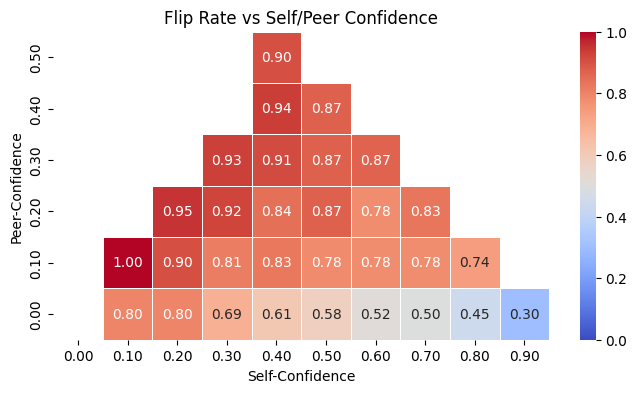

In [24]:
objective_results = []
subjective_results = []
for benchmark in ["OpinionQA", "SIQA", "GlobalOpinionQA"]:
    for disagree_type in ['2nd', 'rnd', 'lst']:
        PATH = f'../data/{benchmark}/results/one_{disagree_type}.pkl'
        with open(PATH, 'rb') as f:
            subjective_results.extend(pickle.load(f))

for benchmark in ["MMLU-Pro", "GPQA-Diamond", "ARC"]:
    for disagree_type in ['2nd', 'rnd', 'lst']:
        PATH = f'../data/{benchmark}/results/one_{disagree_type}.pkl'
        with open(PATH, 'rb') as f:
            objective_results.extend(pickle.load(f))

results = objective_results + subjective_results

# Extract accuracy and confidence
# accuracy = np.array([r['r'] == r['answer'] for r in results])
flip_rate = np.array([r['r'] != r['r^org'] for r in results])
self_conf = np.array([r['p_r^org'] for r in results])
other_conf = np.array([r['p_r_j'] for r in results])

# Bin confidence scores into 10 bins from 0 to 1
bins = np.linspace(0, 1, 11)
row_bin_indices = np.digitize(other_conf, bins) - 1  # Adjust bin index to start at 0
col_bin_indices = np.digitize(self_conf, bins) - 1

heatmap_matrix = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        indices = (row_bin_indices == i) & (col_bin_indices == j)
        if np.any(indices):
            avg_acc = flip_rate[indices].mean()
        else:
            avg_acc = np.nan
        heatmap_matrix[i, j] = avg_acc

row_labels = ['{:.2f}'.format(i/10) for i in range(10)]
col_labels = ['{:.2f}'.format(i/10) for i in range(10)]
x_label = 'Self-Confidence'
y_label = 'Peer-Confidence'
title = 'Flip Rate vs Self/Peer Confidence'
vlimit = (0, 1)
df = pd.DataFrame(heatmap_matrix, index=row_labels, columns=col_labels)
df = df.iloc[::-1]
df = df.dropna(how='all')

plt.figure(figsize=(8, 4))

if vlimit:
    vmin, vmax = vlimit
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=vmin, vmax=vmax)
else:
    sns.heatmap(df, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)
plt.show()


### diff in self/peer confidence or objective/subjective

In [25]:
df_objective = pd.DataFrame()
df_objective["p_r^org"] = [r['p_r^org'] for r in objective_results]
df_objective["p_r_j"] = [r['p_r_j'] for r in objective_results]
df_objective["change"] = [r['r'] == r['r_j'] for r in objective_results]
df_objective["task"] = "objective"

df_subjective = pd.DataFrame()
df_subjective["p_r^org"] = [r['p_r^org'] for r in subjective_results]
df_subjective["p_r_j"] = [r['p_r_j'] for r in subjective_results]
df_subjective["change"] = [r['r'] == r['r_j'] for r in subjective_results]
df_subjective["task"] = "subjective"

df_all = pd.concat([df_objective, df_subjective], ignore_index=True)
df_all["diff_p"] = df_all["p_r^org"] - df_all["p_r_j"]

In [26]:
import pandas as pd
import statsmodels.formula.api as smf

# Convert 'change' to integer (0/1)
df_all['change'] = df_all['change'].astype(int)

# Ensure 'task' is a categorical variable
df_all['task'] = df_all['task'].astype('category')

# Fit logistic regression model
model = smf.logit(formula='change ~ diff_p + task + task * diff_p', data=df_all).fit()

# Show summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.466880
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 change   No. Observations:                58251
Model:                          Logit   Df Residuals:                    58247
Method:                           MLE   Df Model:                            3
Date:                Sat, 17 May 2025   Pseudo R-squ.:                  0.2072
Time:                        03:11:51   Log-Likelihood:                -27196.
converged:                       True   LL-Null:                       -34306.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.5433      0.033     46.597      0.000       1.

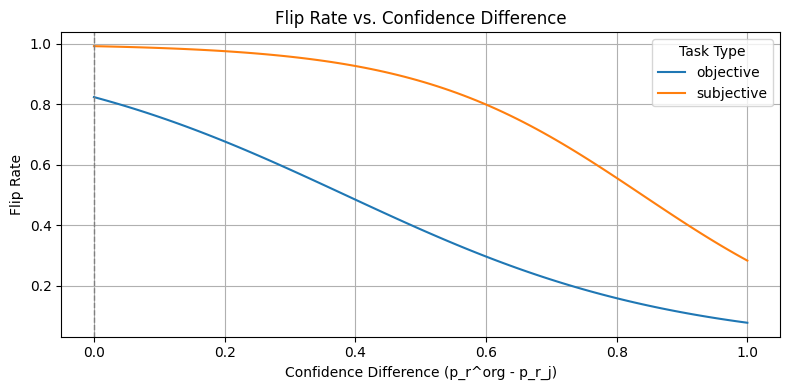

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare prediction range
diff_p_range = np.linspace(df_all["diff_p"].min(), df_all["diff_p"].max(), 100)

# Create a dataframe for predictions
predict_df = pd.DataFrame({
    "diff_p": np.tile(diff_p_range, 2),
    "task": np.repeat(["objective", "subjective"], len(diff_p_range))
})

# Predict probabilities
predict_df["change_prob"] = model.predict(predict_df)

# Plot
plt.figure(figsize=(8, 4))
sns.lineplot(data=predict_df, x="diff_p", y="change_prob", hue="task")
plt.title("Flip Rate vs. Confidence Difference")
plt.xlabel("Confidence Difference (p_r^org - p_r_j)")
plt.ylabel("Flip Rate")
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(title="Task Type")
plt.grid(True)
plt.tight_layout()
plt.show()

## C2: Format of Peer Information

### Data Sampling (200 cap)

In [ ]:
# benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
# for benchmark in benchmarks:
#     with open(f'../data/{benchmark}/results/org.pkl', 'rb') as f:
#         res_org = pickle.load(f)
#     sample_size = min(200, len(res_org))
#     sample_res_org = random.Random(benchmark).sample(res_org, sample_size)
#     with open(f'../data/{benchmark}/sample_results/org.pkl', 'wb') as f:
#         pickle.dump(sample_res_org, f)
    

### Data Generation

In [ ]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org.pkl', 'rb') as f:
        res_org = pickle.load(f)


    input_feat_list = []
    for disagree_size in range(1, 6): # row
        input_row = []
        for agree_size in range(1, 6): # column
            
            eval_feat = {
                'type': 'grp_count',
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'factual' if benchmark in factual else 'opinion',
                'order': 'random'
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(res_org, input_feat_list)

    with open(f'../data/{benchmark}/sample_results/grp_count.pkl', 'wb') as f:
        pickle.dump(results, f)


In [3]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org.pkl', 'rb') as f:
        res_org = pickle.load(f)


    input_feat_list = []
    for disagree_size in range(1, 6): # row
        input_row = []
        for agree_size in range(1, 6): # column
            
            eval_feat = {
                'type': 'grp_ratio',
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'factual' if benchmark in factual else 'opinion',
                'order': 'random'
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(res_org, input_feat_list)

    with open(f'../data/{benchmark}/sample_results/grp_ratio.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing grp_ratio samples...


Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing: 100%|██████████| 5000/5000 [02:12<00:00, 37.85it/s]


Processing grp_ratio samples...


Processing: 100%|██████████| 4950/4950 [02:06<00:00, 39.06it/s]


Processing grp_ratio samples...


Processing: 100%|██████████| 5000/5000 [02:08<00:00, 38.94it/s]


Processing grp_ratio samples...


Processing: 100%|██████████| 5000/5000 [02:08<00:00, 39.01it/s]


Processing grp_ratio samples...


Processing: 100%|██████████| 5000/5000 [02:10<00:00, 38.27it/s]


Processing grp_ratio samples...


Processing: 100%|██████████| 5000/5000 [02:09<00:00, 38.72it/s]


In [4]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org.pkl', 'rb') as f:
        res_org = pickle.load(f)


    input_feat_list = []
    for disagree_size in range(1, 6): # row
        input_row = []
        for agree_size in range(1, 6): # column
            
            eval_feat = {
                'type': 'grp_list',
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'factual' if benchmark in factual else 'opinion',
                'order': 'random'
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(res_org, input_feat_list)

    with open(f'../data/{benchmark}/sample_results/grp_list.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing grp_list samples...


Processing: 100%|██████████| 5000/5000 [02:07<00:00, 39.07it/s]


Processing grp_list samples...


Processing: 100%|██████████| 4950/4950 [02:10<00:00, 38.01it/s]


Processing grp_list samples...


Processing: 100%|██████████| 5000/5000 [02:12<00:00, 37.65it/s]


Processing grp_list samples...


Processing: 100%|██████████| 5000/5000 [02:13<00:00, 37.49it/s]


Processing grp_list samples...


Processing: 100%|██████████| 5000/5000 [02:10<00:00, 38.33it/s]


Processing grp_list samples...


Processing: 100%|██████████| 5000/5000 [02:08<00:00, 38.90it/s]


In [2]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org.pkl', 'rb') as f:
        res_org = pickle.load(f)

    org_reason = qa.qa_generate_reason(res_org, '2nd', 5)

    with open(f'../data/{benchmark}/sample_results/org_reason.pkl', 'wb') as f:
        pickle.dump(org_reason, f)

Processing: 100%|██████████| 2000/2000 [02:02<00:00, 16.37it/s]


In [3]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org_reason.pkl', 'rb') as f:
        org_reason = pickle.load(f)

    input_feat_list = []
    for disagree_size in range(1, 6): # row
        input_row = []
        for agree_size in range(1, 6): # column
            
            eval_feat = {
                'type': 'grp_disc',
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'factual' if benchmark in factual else 'opinion',
                'order': 'random',
                'use_reason': False
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(org_reason, input_feat_list)

    with open(f'../data/{benchmark}/sample_results/grp_disc.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing grp_disc samples...


Processing:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing: 100%|██████████| 5000/5000 [02:40<00:00, 31.20it/s]


Processing grp_disc samples...


Processing: 100%|██████████| 4950/4950 [02:37<00:00, 31.44it/s]


Processing grp_disc samples...


Processing: 100%|██████████| 5000/5000 [02:23<00:00, 34.85it/s]


Processing grp_disc samples...


Processing: 100%|██████████| 5000/5000 [02:31<00:00, 33.05it/s]


Processing grp_disc samples...


Processing: 100%|██████████| 5000/5000 [02:33<00:00, 32.56it/s]


Processing grp_disc samples...


Processing: 100%|██████████| 5000/5000 [02:21<00:00, 35.28it/s]


In [ ]:
benchmarks = ["MMLU-Pro", "GPQA-Diamond", "ARC", "OpinionQA", "GlobalOpinionQA", "SIQA"]
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]

for benchmark in benchmarks:

    with open(f'../data/{benchmark}/sample_results/org_reason.pkl', 'rb') as f:
        org_reason = pickle.load(f)

    input_feat_list = []
    for disagree_size in range(1, 6): # row
        input_row = []
        for agree_size in range(1, 6): # column
            
            eval_feat = {
                'type': 'grp_disc',
                'agree_size': agree_size,
                'disagree_size': disagree_size,
                'disagree_type': '2nd',
                'q_type': 'factual' if benchmark in factual else 'opinion',
                'order': 'random',
                'use_reason': True
            }
            input_row.append(eval_feat)
        input_feat_list.append(input_row)

    results, accuracy = qa.qa_eval_matrix(org_reason, input_feat_list)

    with open(f'../data/{benchmark}/sample_results/grp_reason.pkl', 'wb') as f:
        pickle.dump(results, f)

### Table 3: Format of Peer Information

In [59]:
def flatten(nested_list):
    flat = []
    for item in nested_list:
        if isinstance(item, list):
            flat.extend(flatten(item))
        else:
            flat.append(item)
    return flat

def p_value_to_stars(p_value):
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return ""

In [56]:
factual_results[0]

{'question_id': 9997,
 'question': 'The negative muon, mu^-, has properties most similar to which of the following?',
 'options': ['Gluon',
  'Electron',
  'Quark',
  'Proton',
  'Photon',
  'Boson',
  'Meson',
  'Neutron'],
 'answer': 'B',
 'answer_index': 1,
 'cot_content': '',
 'category': 'physics',
 'src': 'ori_mmlu-college_physics',
 'r^org': 'B',
 'p_r^org': np.float64(1.0),
 'topk^org': [('B', np.float64(1.0)),
  ('C', np.float64(0.0)),
  ('D', np.float64(0.0)),
  ('A', np.float64(0.0)),
  ('F', np.float64(0.0)),
  ('E', np.float64(0.0)),
  ('H', np.float64(0.0)),
  ('G', np.float64(0.0))],
 'R_p': 'B',
 'R_n': 'C',
 'p_R_p': np.float64(1.0),
 'p_R_n': np.float64(0.0),
 'r': 'B',
 'p_r': np.float64(1.0),
 'topk': [('B', np.float64(1.0)),
  ('C', np.float64(0.0)),
  ('A', np.float64(0.0)),
  ('D', np.float64(0.0)),
  ('F', np.float64(0.0)),
  ('E', np.float64(0.0)),
  ('H', np.float64(0.0)),
  ('G', np.float64(0.0))],
 'agree_size': 1,
 'disagree_size': 1,
 'disagree_type': '2nd

In [62]:
with open(f'../data/MMLU-Pro/sample_results/grp_ratio.pkl', 'rb') as f:
    temp = pickle.load(f)

In [63]:
temp['data'][0][0][0]

{'question_id': 9997,
 'question': 'The negative muon, mu^-, has properties most similar to which of the following?',
 'options': ['Gluon',
  'Electron',
  'Quark',
  'Proton',
  'Photon',
  'Boson',
  'Meson',
  'Neutron'],
 'answer': 'B',
 'answer_index': 1,
 'cot_content': '',
 'category': 'physics',
 'src': 'ori_mmlu-college_physics',
 'r^org': 'B',
 'p_r^org': np.float64(1.0),
 'topk^org': [('B', np.float64(1.0)),
  ('C', np.float64(0.0)),
  ('D', np.float64(0.0)),
  ('A', np.float64(0.0)),
  ('F', np.float64(0.0)),
  ('E', np.float64(0.0)),
  ('H', np.float64(0.0)),
  ('G', np.float64(0.0))],
 'R_p': 'B',
 'R_n': 'C',
 'p_R_p': np.float64(1.0),
 'p_R_n': np.float64(0.0),
 'r': 'B',
 'p_r': np.float64(1.0),
 'topk': [('B', np.float64(1.0)),
  ('C', np.float64(0.0)),
  ('A', np.float64(0.0)),
  ('D', np.float64(0.0)),
  ('F', np.float64(0.0)),
  ('E', np.float64(0.0)),
  ('H', np.float64(0.0)),
  ('G', np.float64(0.0))],
 'group_size': 2,
 'disagree_ratio': 0.5,
 'disagree_type': '

In [ ]:
factual = ["MMLU-Pro", "GPQA-Diamond", "ARC"]
opinion = ["OpinionQA", "GlobalOpinionQA", "SIQA"]
method_list = ['grp_count', 'grp_ratio', 'grp_list', 'grp_disc', 'grp_reason']

table2 = pd.DataFrame(columns = ["Method", 
                                 'Mean Flip Rate - Factual', 'Mean Flip Rate - Opinion',
                                 '#A - Factual', '#A - Opinion',
                                 '#D - Factual', '#D - Opinion',
                                 '#A - D - Factual', '#A - D - Opinion',])

for method in method_list:
    target_row = [method]
    factual_results = []
    opinion_results = []
    for benchmark in factual:
        with open(f'../data/{benchmark}/sample_results/{method}.pkl', 'rb') as f:
            factual_results.append(pickle.load(f)['data'])
    for benchmark in opinion:
        with open(f'../data/{benchmark}/sample_results/{method}.pkl', 'rb') as f:
            opinion_results.append(pickle.load(f)['data'])

    factual_results = flatten(factual_results)
    opinion_results = flatten(opinion_results)

    # Mean
    for results in [factual_results, opinion_results]:
        flip_list = [int(x['r'] != x['r^org']) for x in results]
        mean_flip_rate = np.mean(flip_list)
        target_row.append(round(mean_flip_rate, 2))

    # number of agree
    for results in [factual_results, opinion_results]:
        flip_list = [int(x['r'] != x['r^org']) for x in results]
        try:
            agree_size_list = [x['agree_size'] for x in results]
        except:
            agree_size_list = [int(x['group_size']*(1-x['disagree_ratio'])) for x in results]
        r_value, p_value = pearsonr(flip_list, agree_size_list)
        target_row.append(f"{r_value:.2f}{p_value_to_stars(p_value)}")

    # number of disagree
    for results in [factual_results, opinion_results]:
        flip_list = [int(x['r'] != x['r^org']) for x in results]
        try:
            disagree_size_list = [x['disagree_size'] for x in results]
        except:
            disagree_size_list = [int(x['group_size']*x['disagree_ratio']) for x in results]
        r_value, p_value = pearsonr(flip_list, disagree_size_list)
        target_row.append(f"{r_value:.2f}{p_value_to_stars(p_value)}")

    # number of agree - disagree
    for results in [factual_results, opinion_results]:
        flip_list = [int(x['r'] != x['r^org']) for x in results]
        try:
            agree_size_list = [x['agree_size'] for x in results]
        except:
            agree_size_list = [int(x['group_size']*(1-x['disagree_ratio'])) for x in results]
        try:
            disagree_size_list = [x['disagree_size'] for x in results]
        except:
            disagree_size_list = [int(x['group_size']*x['disagree_ratio']) for x in results]
        agree_diff_list = np.array(agree_size_list) - np.array(disagree_size_list)
        r_value, p_value = pearsonr(flip_list, agree_diff_list)
        target_row.append(f"{r_value:.2f}{p_value_to_stars(p_value)}")

    table2.loc[len(table2)] = target_row
        





In [67]:
table2

,Method,Mean Flip Rate - Factual,Mean Flip Rate - Opinion,#A - Factual,#A - Opinion,#D - Factual,#D - Opinion,#A - D - Factual,#A - D - Opinion
0,grp_count,0.21,0.26,-0.18***,-0.34***,0.18***,0.31***,-0.25***,-0.46***
1,grp_ratio,0.22,0.30,-0.27***,-0.41***,0.25***,0.39***,-0.36***,-0.55***
2,grp_list,0.21,0.28,-0.19***,-0.23***,0.22***,0.29***,-0.29***,-0.37***
3,grp_disc,0.21,0.28,-0.15***,-0.25***,0.15***,0.27***,-0.21***,-0.37***
4,grp_reason,0.33,0.29,-0.06***,-0.08***,0.05***,0.07***,-0.07***,-0.10***


# DUMP

## ETHICS

In [ ]:
df_raw = pd.read_csv('../data/ETHICS/raw/cm_test.csv')

In [ ]:
ethics_full = []
for i, row in df_raw.iterrows():
    input_ele = {}
    input_ele['question_id'] = i
    input_ele['question'] = "Question: Would most people believe this reasonable or unreasonable to say?\n" + row['input'] 
    choices = ['reasonable', 'unreasonable']
    random.Random(i).shuffle(choices)
    input_ele['options'] = choices
    label = row['label']
    label_text = ['reasonable', 'unreasonable'][label]
    true_label = choices.index(label_text)
    answer = 'AB'[true_label]
    input_ele['answer'] = answer

    ethics_full.append(input_ele)

In [ ]:
with open('../data/ETHICS/results/full.pkl', 'wb') as f:
    pickle.dump(ethics_full, f)

print("total number of questions in ETHICS:", len(ethics_full))

res_org = qa.qa_eval_org(ethics_full)

with open('../data/ETHICS/results/org.pkl', 'wb') as f:
    pickle.dump(res_org, f)

total number of questions in ETHICS: 3885


Processing QA: 100%|██████████| 3885/3885 [01:20<00:00, 48.15it/s]


In [ ]:
with open('../data/ETHICS/results/org.pkl', 'rb') as f:
    res_org = pickle.load(f)

type_names = ['1st', '2nd', 'rnd', 'lst']

for disagree_type in type_names:
    results = qa.qa_eval_one(res_org, disagree_type)
    with open(f'../data/ETHICS/results/one_{disagree_type}.pkl', 'wb') as f:
        pickle.dump(results, f)

Processing QA: 100%|██████████| 3885/3885 [01:08<00:00, 56.37it/s]
